# Library Imports

In [1]:
import random
import numpy as np                  # Numpy numerical library
import pandas as pd                 # Pandas for dataframes manipulation
import tensorflow as tf             # TensorFlow for neural networks and deep learning APIs
import matplotlib.pyplot as plt     # Plotting
from sklearn.metrics import precision_score, recall_score # Importing performance metrics calculators
%matplotlib inline                  

# Dataset Preparation

In [2]:
BATCH_SIZE = 64                 # Default batch size
TRAIN_SPLIT_PERCENT = 0.8       # Percentage of the data for training, rest for testing  

class DataLoader:
    # Take in a csv file and extracts features and labels
    def __init__(self, csv_filepath, batch_size):                          
        
        self.df_samples = pd.read_csv(csv_filepath)                 # Create a pandas dataframe
        self.numpy_samples = self.df_samples.to_numpy()
        
        self.states_features = self.numpy_samples[:, 1:self.numpy_samples.shape[1]-1]               # Take the feature values for states, also ignore first column for IDs  
        self.feature_dim = self.states_features.shape[1]                                        
        self.actions_labels = self.numpy_samples[:, -1].reshape(-1, 1)                              # The action labels separated from the labels
        self.actions_classes = np.amax(self.actions_labels) + 1                                     # Number of different action classes to set the output layer dimensions (+1 bec starts at zero)
        self.actions_set = np.arange(self.actions_classes).tolist()                                 # Set of all possible actions 
        self.train_batches, self.test_batches = self.prepare_batches(batch_size, train_split_percent= TRAIN_SPLIT_PERCENT)
        print("Dataset successfully loaded with {} training batches, and {} testing batches with {} batch size.".format(
            len(self.train_batches), len(self.test_batches), self.batch_size
        ))
        
    def prepare_batches(self, batch_size, train_split_percent):
        states_t = self.states_features[:-1, :].copy()           # Considered as S(t)
        states_t_plus_one = self.states_features[1:, :].copy()   # Considered as S(t+1)
        actions_star_t = self.actions_labels[:-1, :].copy()      # Considered as a*(t)

        whole_generic_samples = np.hstack((states_t, actions_star_t, states_t_plus_one))            # Stack the whole dataset as described in the paper

        np.random.seed(0)                                   # To shuffle similarly each time, comment to disable this feature
        np.random.shuffle(whole_generic_samples)            # Shuffle the dataset
        
        self.n_samples = whole_generic_samples.shape[0]
        self.batch_size = batch_size
        self.n_batches = np.ceil(self.n_samples / self.batch_size).astype(np.uint32)

        train_batches = []        # Empty list to hold the batches of whole data
        test_batches = []

        # Prepare the data into batches
        for i in range(self.n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            curr_batch = whole_generic_samples[start:end, :]
            if (i / self.n_batches) < train_split_percent:    
                train_batches.append(curr_batch)
            else:
                test_batches.append(curr_batch)
        
        self.n_train_batches = len(train_batches)
        self.n_test_batches = len(test_batches)
        return train_batches, test_batches
    
    # Function that takes in the 2D arrays of data and converts lo lists of tuples to be compatible with looping while training
    # TODO: Enhancing these function (All the following isn't used)
    def tupelize(self, array):
        list_of_tuples = list(zip(array.T[0], array.T))
        return list_of_tuples 

    # Function to get the unique rows representing unique states, returns a numpy array of rows
    def get_unique_rows(self):
        self.unique_rows = np.unique(self.states_features, axis = 0)
        return self.unique_rows

    # Get the pandas dataframe for the data, returns a pandas dataframe
    def get_dataframe(self):    
        return self.df_samples
        

# Model and Classes Definition

In [3]:
LEARNING_RATE = 0.001    # Gradient-descent learning rate    
EPSILON = 0.8            # Epsilon value for the epsilon greedy policy selection
LAMBDA = 0.01            # Discount factor for loss calculation
EPOCHS = 10              # Number of training epochs

# Creating our main class for our DQN
class DeepQNet:
    
    def __init__(self, dataset):
        self.data = dataset                                         # Storing the data in our QNet            
        self.input_dim = dataset.feature_dim                        # State feature dim
        self.output_dim = dataset.actions_classes
        
        self.model = self.create_model()                            # Main DQN model

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0
    
    def create_model(self):
        # Definition of the neural network architecture mentioned in the paper (3 relu feedforward layers)
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(self.input_dim))                                # Input dimension of the state-vector
        model.add(tf.keras.layers.Dense(32, activation= "relu"))
        model.add(tf.keras.layers.Dense(32, activation= "relu"))
        model.add(tf.keras.layers.Dense(self.output_dim, activation= "softmax"))           # Output is value function selection
        #model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.Adam(lr= LEARNING_RATE, clipnorm=1.0), metrics=['accuracy'])
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr= LEARNING_RATE, clipnorm=1.0), metrics=['accuracy'])
        return model

    def load_model(self, path):
        self.model = tf.keras.models.load_model(path)

    # Prints the model details
    def summary(self):
        self.model.summary()

    def get_reward(self, predicted_actions, optimal_actions):
        predicted_actions = np.asarray(predicted_actions).reshape(-1)
        optimal_actions = np.asarray(optimal_actions).reshape(-1)
        reward_vector = np.equal(predicted_actions, optimal_actions).astype(np.uint32)
        return reward_vector

    # Function to implement the epsilon-greedy policy selection, returns the index of the selected action
    def greedy(self, actions_values_vec, epsilon):
        random.seed(a=None, version=2)               # Change the seed of randomization
        num_in_curr_batch = actions_values_vec.shape[0]
        selections = []
        for i in range(num_in_curr_batch):
            p = random.uniform(0.0, 1.0)
            if p < epsilon:
                curr_actions_values = actions_values_vec[i, :].reshape(-1)
                selections.append(np.argmax(curr_actions_values))
            else:
                random_selection = np.random.randint(low=0, high=self.data.actions_classes)
                selections.append(random_selection)
        
        return np.asarray(selections)

    # Function to process the batch and split the S(t), a*(t), and S(t+1)
    def process_batch(self, batch):
        current_states = batch[:, :self.data.feature_dim]
        optimal_actions = batch[:, self.data.feature_dim].astype(np.uint32)
        next_states = batch[:, self.data.feature_dim+1 :]
        return current_states, optimal_actions, next_states

    def train(self, save_path=None):
        
        losses = []
        accuracies = []
        batches = self.data.train_batches               # Get the batches 

        for epoch in range(EPOCHS):

            for batch_idx, batch in enumerate(batches):                   # Looping over the batches
                current_states, optimal_actions, next_states = self.process_batch(batch)

                # Prediction on S(t)
                estimated_qs_vec_t = self.model.predict(current_states)
                predicted_actions_t = self.greedy(estimated_qs_vec_t, epsilon= EPSILON)             # Predict the actions based on epsilon-greedy algorithm
                rewards_t = self.get_reward(predicted_actions_t, optimal_actions)                   # Get the reward for each sample, the variable here unused becuase the rewarding phenomenon
                                                                                                    # is already done implicitly down while putting 1's in the q_values of optimal actions
                
                # Prediction on S(t+1)
                estimated_qs_vec_t_plus_one = self.model.predict(next_states)
                predicted_actions_t_plus_one = self.greedy(estimated_qs_vec_t_plus_one, epsilon= 1.0)     # Taking the always argmax (epsilon = 1.0)
                
                # An np.arange object to access all rows, for vectorization
                all_rows_idx = np.arange(estimated_qs_vec_t.shape[0])

                # Prediction with S(t+1) and a_cap(t+1)
                q_cap_t_plus_one = self.model.predict(next_states)[all_rows_idx, predicted_actions_t_plus_one]  # Getting the q_values for the next predicted actions
                
                # Calculation of qref
                qref = np.zeros_like(estimated_qs_vec_t)                                                # Set the qref shape and initialize as zeros
                qref[all_rows_idx, optimal_actions] = 1                                                 # Setting 1 to all values that correspond to the action of maximum value.
                qref[all_rows_idx, predicted_actions_t] += LAMBDA * q_cap_t_plus_one                    # qref = rt + qcap_t+1
                #qref_softmax = np.zeros_like(qref)                                                     # Softmax here is just for intuition, while what we do here is a hard max.
                #qref_softmax[all_rows_idx, qref.argmax(1)] = 1                                         # Replace the max value of the function by 1, all others by zeros. To act like classifier
                
                # This line bypasses the RL exploration, makes the agent works as an ordinal NN (uncomment if you want this to happen.)
                #qref_softmax = tf.keras.utils.to_categorical(optimal_actions)

                loss, accuracy = self.model.train_on_batch(current_states, qref, reset_metrics= False)
                losses.append(loss)
                accuracies.append(accuracy)
                #self.model.fit(current_states, qref_softmax)
                #continue
            
                print(" -------------------------------------------------- ")
                print("In epoch {}/{} epochs, batch {}/{} batches:".format(epoch+1, EPOCHS, batch_idx+1, self.data.n_train_batches))
                print("Accuracy: {}".format(accuracy))
                print("Loss: {}".format(loss))
                print(" -------------------------------------------------- ")
        
        if save_path != None:
            self.model.save(save_path)

        return losses, accuracies
 
    def test(self):
        batches = self.data.test_batches
        
        accuracy = 0
        f1_score = 0
        precision = 0
        recall = 0

        for batch_idx, batch in enumerate(batches):                             # Looping over the batches
            current_states, optimal_actions, _ = self.process_batch(batch)      # Get the data from the batch
            estimated_qs_vec = self.model.predict(current_states)
            predicted_actions = self.greedy(estimated_qs_vec, epsilon= 1.0).squeeze()     # Since we are testing so we need no exploration, we are only greedy now (eps=1.0)
            #print(np.unique(predicted_actions))

            curr_batch_accuracy = np.mean(np.equal(predicted_actions, optimal_actions).astype(np.uint32)) 
            curr_batch_precision = precision_score(optimal_actions, predicted_actions, labels= self.data.actions_set, average="weighted", zero_division= 1)
            curr_batch_recall = recall_score(optimal_actions, predicted_actions, labels= self.data.actions_set, average="weighted", zero_division= 1)
            curr_batch_f1 = 2*((curr_batch_precision*curr_batch_recall)/(curr_batch_precision+curr_batch_recall+1e-7))

            accuracy += curr_batch_accuracy / len(batches)
            precision += curr_batch_precision / len(batches) 
            recall += curr_batch_recall / len(batches)
            f1_score += curr_batch_f1 / len(batches)
        
        print("Finished testing on the testing dataset, now printing metrics.")
        print("Accuracy: {}".format(accuracy))
        print("Precision: {}".format(precision))
        print("Recall: {}".format(recall))
        print("F1 Score: {}".format(f1_score))
        return accuracy, precision, recall, f1_score

    def predict(self, states):
        estimated_qs = self.model.predict(states)
        predicted_action = self.greedy(estimated_qs, epsilon=1.0).squeeze()
        return predicted_action

    
    

# Model Training

In [4]:
# Training our model
data = DataLoader("data/ids_data.csv", batch_size= BATCH_SIZE)              # Importing the dataset using our dataloader
dq_net = DeepQNet(dataset= data)                                            # Creating our DQNet
dq_net.summary()                                                            # Printing the model contents
losses, accuracies = dq_net.train(save_path= "models/ids_dqnet.ckpt")       # Calling the train function

Dataset successfully loaded with 1213 training batches, and 303 testing batches with 64 batch size.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 2,184
Trainable params: 2,184
Non-trainable params: 0
_________________________________________________________________
 -------------------------------------------------- 
In epoch 1/10 epochs, batch 1/1213 batches:
Accuracy: 0.046875
Loss: 0.2320382297039032
 -------------------------------------------------- 
 -------------------------------------------------- 
In epoch 1/10 epochs, batch 2/1213 ba

# Plotting Performance Curves

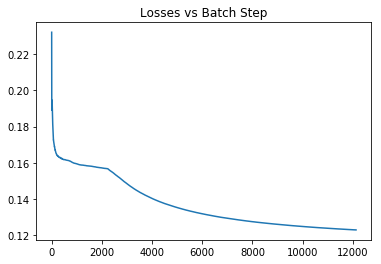

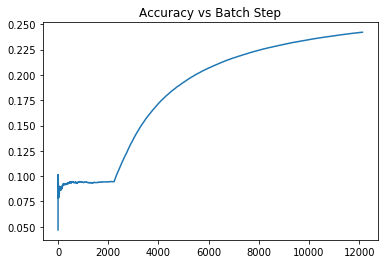

In [5]:
# Using plotting techniques to visualize the performance curves of training our model.
plt.title("Losses vs Batch Step")
plt.plot(losses)
plt.figure()
plt.title("Accuracy vs Batch Step")
plt.plot(accuracies)

# Model Testing and Evaluation

In [6]:
# Testing our model
data = DataLoader("data/ids_data.csv", batch_size= BATCH_SIZE)              # Importing the dataset using our dataloader
dq_net = DeepQNet(dataset= data)                                            # Creating our DQNet
dq_net.load_model("models/ids_dqnet.ckpt")
dq_net.test()   

Dataset successfully loaded with 1213 training batches, and 303 testing batches with 64 batch size.
Finished testing on the testing dataset, now printing metrics.
Accuracy: 0.2740749829293271
Precision: 0.9451404389448876
Recall: 0.2740749829293271
F1 Score: 0.42182511702709136


(0.2740749829293271,
 0.9451404389448876,
 0.2740749829293271,
 0.42182511702709136)

# Inference on a Single Samples

In [ ]:
dq_net = DeepQNet(dataset= data)
dq_net.load_model("models/ids_dqnet.ckpt")
idx = 96142                                                                   # Getting a point from the dataset
test_point = data.states_features[idx].reshape(1, data.feature_dim)           # Getting the features
true_label = data.actions_labels[idx]                                         # Getting the true action
print(test_point)                                                             # Printing the features
out = dq_net.predict(test_point)                                              # Perform the feeding
print("Our DQN predicted the action: {}".format(out))       
print("True (ground truth) action: {}".format(true_label))